## Dependencies

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import inflection
import warnings
warnings.filterwarnings('ignore')

!cp ../script/common_function.py ../notebook
pd.set_option('max_columns', 50)

## Load the dataset

In [2]:
df = pd.read_csv('../dataset/marketing_campaign_data.csv')
df.sample()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
373,373,1245,1966,S1,Lajang,63810000.0,0,1,11-11-2012,45,977000,12000,253000,16000,12000,101000,4,4,3,12,8,0,1,0,0,0,0,3,11,0


## Lowercase column names

In [3]:
df = df.drop(["Unnamed: 0"], axis=1)
df.columns = [inflection.underscore(col) for col in df.columns]
df.sample()

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response
1046,4754,1966,S2,Menikah,33585000.0,0,1,25-09-2013,91,30000,11000,33000,13000,6000,29000,1,2,0,4,4,0,0,0,0,0,0,3,11,0


## Pre-exploration

In [4]:
df.shape

(2240, 29)

In [5]:
from common_function import dataset_summary
summary = dataset_summary(df)
summary.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
variable,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response
no_unique,2240,59,5,6,1974,3,3,663,100,776,158,558,182,177,213,15,15,14,14,16,2,2,2,2,2,2,1,1,2
pandas_dtype,int64,int64,object,object,float64,int64,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
missing_value,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
%_missing_values,0.0,0.0,0.0,0.0,1.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unique_value,"[5524, 2174, 4141, 6182, 5324, 7446, 965, 6177...","[1957, 1954, 1965, 1984, 1981, 1967, 1971, 198...","[S1, S3, S2, SMA, D3]","[Lajang, Bertunangan, Menikah, Cerai, Janda, D...","[58138000.0, 46344000.0, 71613000.0, 26646000....","[0, 1, 2]","[0, 1, 2]","[04-09-2012, 08-03-2014, 21-08-2013, 10-02-201...","[58, 38, 26, 94, 16, 34, 32, 19, 68, 11, 59, 8...","[635000, 11000, 426000, 173000, 520000, 235000...","[88000, 1000, 49000, 4000, 43000, 42000, 65000...","[546000, 6000, 127000, 20000, 118000, 98000, 1...","[172000, 2000, 111000, 10000, 46000, 0, 50000,...","[88000, 1000, 21000, 3000, 27000, 42000, 49000...","[88000, 6000, 42000, 5000, 15000, 14000, 27000...","[3, 2, 1, 5, 4, 15, 7, 0, 6, 9, 12, 8, 10, 13,...","[8, 1, 2, 5, 6, 7, 4, 3, 11, 0, 27, 10, 9, 23,...","[10, 1, 2, 0, 3, 4, 6, 28, 9, 5, 8, 7, 11, 22]","[4, 2, 10, 6, 7, 0, 3, 8, 5, 12, 9, 13, 11, 1]","[7, 5, 4, 6, 8, 9, 20, 2, 3, 1, 10, 0, 14, 19,...","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]",[3],[11],"[1, 0]"


**Observation**
* There are 2240 rows and 29 variables that describe the customer behavior and demographics.
* Only **income** which has 24 rows of missing values.
* **dt_customer** needs to be parsed into datetime type.

From the existing features, we can extract new features as follows:
* From **year_birth**, we can get customer **age** by substracting it with 2022.
* From **marital_status**, we can identify which customer is in **relationship** or not.
* From **kidhome**, and **teenhome**, we know the number of **children** that customer has.
* From new feature, **children**, we can know if the customer is **parent** or not.
* From **dt_customer**, we can get **year_join** of each customer.
* From **mnt_coke**, **mnt_fruits**, **mnt_meat_products**, **mnt_fish_products**, **mnt_sweet_products**, and **mnt_gold_prods**, we sum them all to get **total_amount_spent**.
* From **num_deals_purchases**, **num_web_purchases**, **num_catalog_purchases**, and **num_store_purchases**, we add them all to get **total_purchase_count**.
* From **accepted_cmp3**, **accepted_cmp4**, **accepted_cmp5**, **accepted_cmp1**, and **accepted_cmp2**, add them all to get **total_accepted_campaign**.
* To create **conversion_rate**, we divide **total_purchase_count** by **num_web_visits_month**


## Feature Engineering

In [6]:
def feature_engineering(df):
    df = df.copy()
    
    # age
    df['age'] = 2022 - df['year_birth']

    def age_range(row):
        if (row >= 0) & (row < 10):
            return 'Child'
        if (row >= 10) & (row < 26):
            return 'Gen Z'
        if (row >= 26) & (row < 42):
            return 'Millennials'
        if (row >= 42) & (row < 58):
            return 'Gen X'
        if (row >= 58):
            return 'Boomers'    

    # classified age range 
    # source: https://www.beresfordresearch.com/age-range-by-generation/
    df['age_range'] = df['age'].apply(age_range)
    
    def relationship_status(row):
        if row in ['Bertunangan', 'Menikah']:
            return True
        if row in ['Lajang','Cerai', 'Janda', 'Duda']:
            return False
    
    # in_relationship (True or False)
    df['in_relationship'] = df['marital_status'].apply(relationship_status)
    
    # children
    df['children'] = df[['kidhome', 'teenhome']].sum(axis=1)
    
    # parent
    df['is_parent'] = np.where(df['children'] > 0, 1, 0)
    
    # year join
    df['dt_customer'] = pd.to_datetime(df['dt_customer'])
    df['year_join'] = 2022 - df['dt_customer'].dt.year
    
    # total amount spent
    amount_spent = [
        'mnt_coke', 'mnt_fruits','mnt_meat_products', 
        'mnt_fish_products', 'mnt_sweet_products','mnt_gold_prods'
    ]
    df['total_amount_spent'] = df[amount_spent].sum(axis=1)
    
    # total purchase count
    purchase_count = [
        'num_deals_purchases', 'num_web_purchases',
        'num_catalog_purchases', 'num_store_purchases'
    ]
    df['total_purchase_count'] = df[purchase_count].sum(axis=1)
    
    # total accepted campaign
    accepted_campaign = [
        'accepted_cmp3', 'accepted_cmp4', 
        'accepted_cmp5', 'accepted_cmp1',
        'accepted_cmp2'
    ]
    df['total_accepted_campaign'] = df[accepted_campaign].sum(axis=1)
    
    # conversion rate
    df['conversion_rate'] = 100 * df['total_purchase_count'] / df['num_web_visits_month']
    df['conversion_rate'] = df['conversion_rate'].fillna(0)
    
    # drop missing values
    return df.dropna()

df = feature_engineering(df)
df.sample(5)

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_coke,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response,age,age_range,in_relationship,children,is_parent,year_join,total_amount_spent,total_purchase_count,total_accepted_campaign,conversion_rate
1516,1490,1962,S1,Menikah,55759000.0,0,1,2012-11-28,84,675000,0,85000,10000,7000,77000,5,10,3,8,8,0,0,0,0,0,0,3,11,0,60,Boomers,True,1,1,10,854000,26,0,325.0
283,1672,1974,S3,Bertunangan,65640000.0,0,1,2014-01-03,74,204000,7000,149000,20000,15000,66000,1,5,1,8,2,0,0,0,0,0,0,3,11,0,48,Gen X,True,1,1,8,461000,15,0,750.0
1352,8369,1987,S1,Bertunangan,18227000.0,1,0,2012-08-11,21,1000,2000,7000,4000,3000,11000,1,0,1,2,8,0,0,0,0,0,0,3,11,0,35,Millennials,True,1,1,10,28000,4,0,50.0
80,3332,1985,S1,Lajang,29760000.0,1,0,2012-08-29,87,64000,4000,68000,7000,5000,17000,4,3,1,4,8,0,0,0,0,0,0,3,11,0,37,Millennials,False,1,1,10,165000,12,0,150.0
24,1409,1951,S1,Bertunangan,40689000.0,0,1,2013-03-18,69,270000,3000,27000,39000,6000,99000,7,7,1,5,8,0,0,0,0,0,0,3,11,0,71,Boomers,True,1,1,9,444000,20,0,250.0


## Exploratory Data Analysis

In [7]:
def scatter_and_hist_plot(df, x, y):
    sns.set_theme(style="whitegrid")
    sns.jointplot(data=df, y=y, x=x, kind='reg')
    plt.show()

### Income vs Total Amount Spent

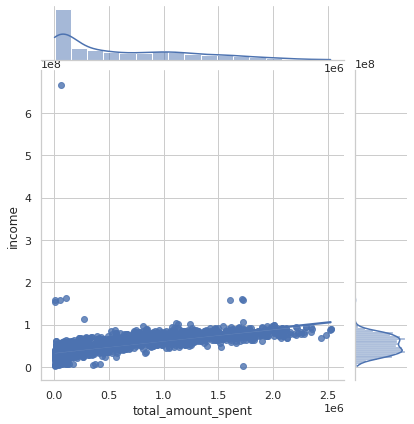

In [8]:
scatter_and_hist_plot(df, x='total_amount_spent', y='income')

### Income vs Conversion Rate

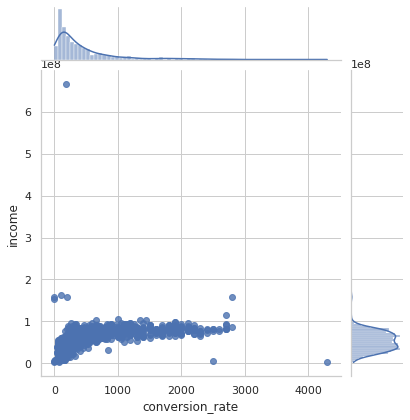

In [9]:
scatter_and_hist_plot(df, x='conversion_rate', y='income')

### Total Amount Spent vs Conversion Rate

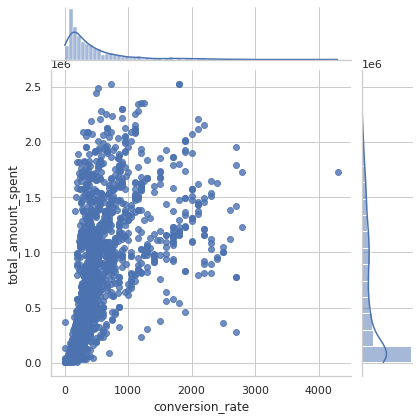

In [10]:
scatter_and_hist_plot(df, x='conversion_rate', y='total_amount_spent')

### Age vs Conversion Rate

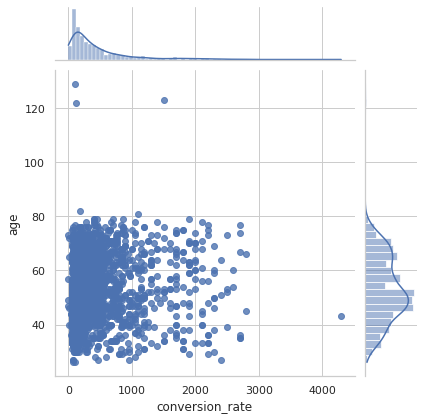

In [11]:
scatter_and_hist_plot(df, x='conversion_rate', y='age')

### Correlation analysis

In [12]:
df.columns

Index(['id', 'year_birth', 'education', 'marital_status', 'income', 'kidhome',
       'teenhome', 'dt_customer', 'recency', 'mnt_coke', 'mnt_fruits',
       'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products',
       'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',
       'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month',
       'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'accepted_cmp1',
       'accepted_cmp2', 'complain', 'z_cost_contact', 'z_revenue', 'response',
       'age', 'age_range', 'in_relationship', 'children', 'is_parent',
       'year_join', 'total_amount_spent', 'total_purchase_count',
       'total_accepted_campaign', 'conversion_rate'],
      dtype='object')

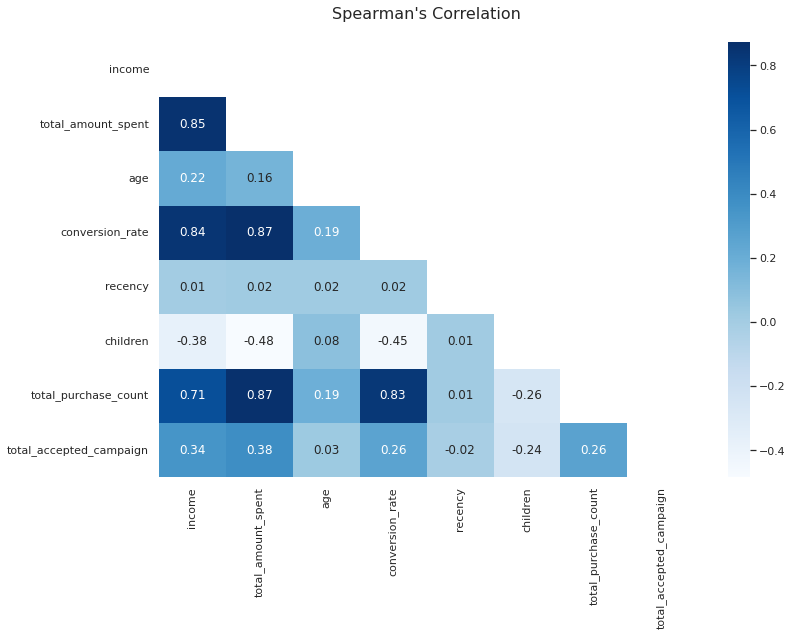

In [13]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
col_to_plot = [
    'income', 'total_amount_spent', 'age', 'conversion_rate',
    'recency', 'children', 'total_purchase_count', 'total_accepted_campaign'
]
corr_df = df[col_to_plot].corr(method='spearman')
sns.heatmap(
    corr_df, 
    ax=ax,
    mask=np.triu(np.ones_like(corr_df)),
    cmap='Blues', 
    annot=True, 
    fmt='.2f'
)
ax.set_title("Spearman's Correlation\n", fontsize=16)
plt.show()

## Data Preprocessing